# Statistics on SVM

We will arange data and train SVC on the data.
Then we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic SVM

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.INFO)
stocks = [TrainingData(sn).add_history(10).set_threshold(0.8).get() for sn in stock_names]

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018134653877025918
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.026397640541565882
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.018548151336335694
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0.036464497748678756
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.0321798749747933


In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [4]:
def run_model(model, stocks=stocks):
    scores = {sn: [] for sn in stock_names}
    validation_rounds = 3
    for i in range(validation_rounds):
        for sn, (data, classes) in zip(stock_names, stocks):
            scores[sn].append(sum(cross_val_score(model, data, classes))/3) 
    for sn in scores.keys():
        scores[sn] = sum(scores[sn])/validation_rounds
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

In [5]:
from sklearn.svm import SVC
import traceback

# create iterables for all options and use itertools product
C=[0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
kernel=['linear', 'poly', 'rbf', 'sigmoid']
max_iter=[3, 10, 20, 100, 500, 1000]

svm_models = [SVC(C=c, kernel=k, max_iter=mi) 
          for c, k, mi in product(C, kernel, max_iter)]

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    saccuracies = list(map(run_model, svm_models))

In [7]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(svm_models, saccuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.kernel, model.max_iter, sn, acc))

sresults = DataFrame(data, columns=('C', 'kernel', 'max_iter', 'stock', 'accuracy'))

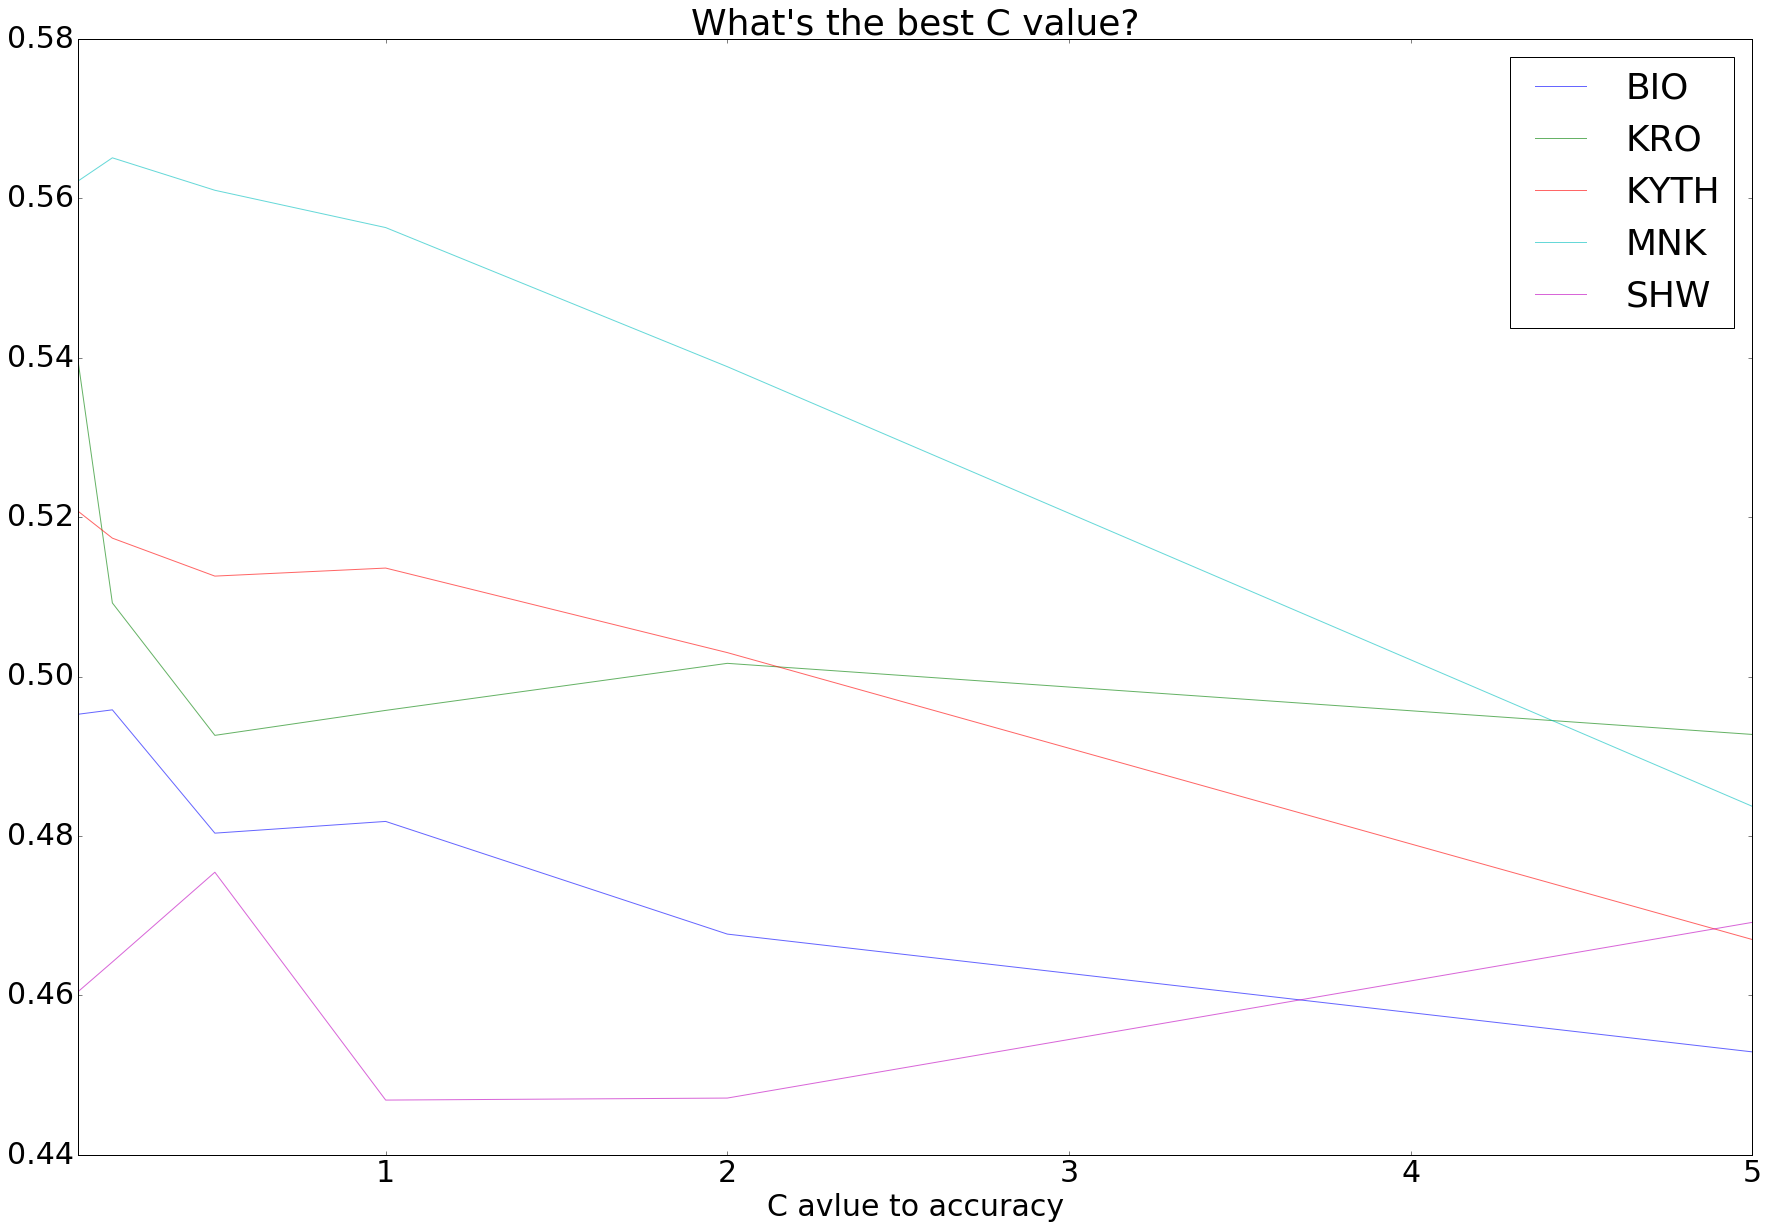

In [8]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

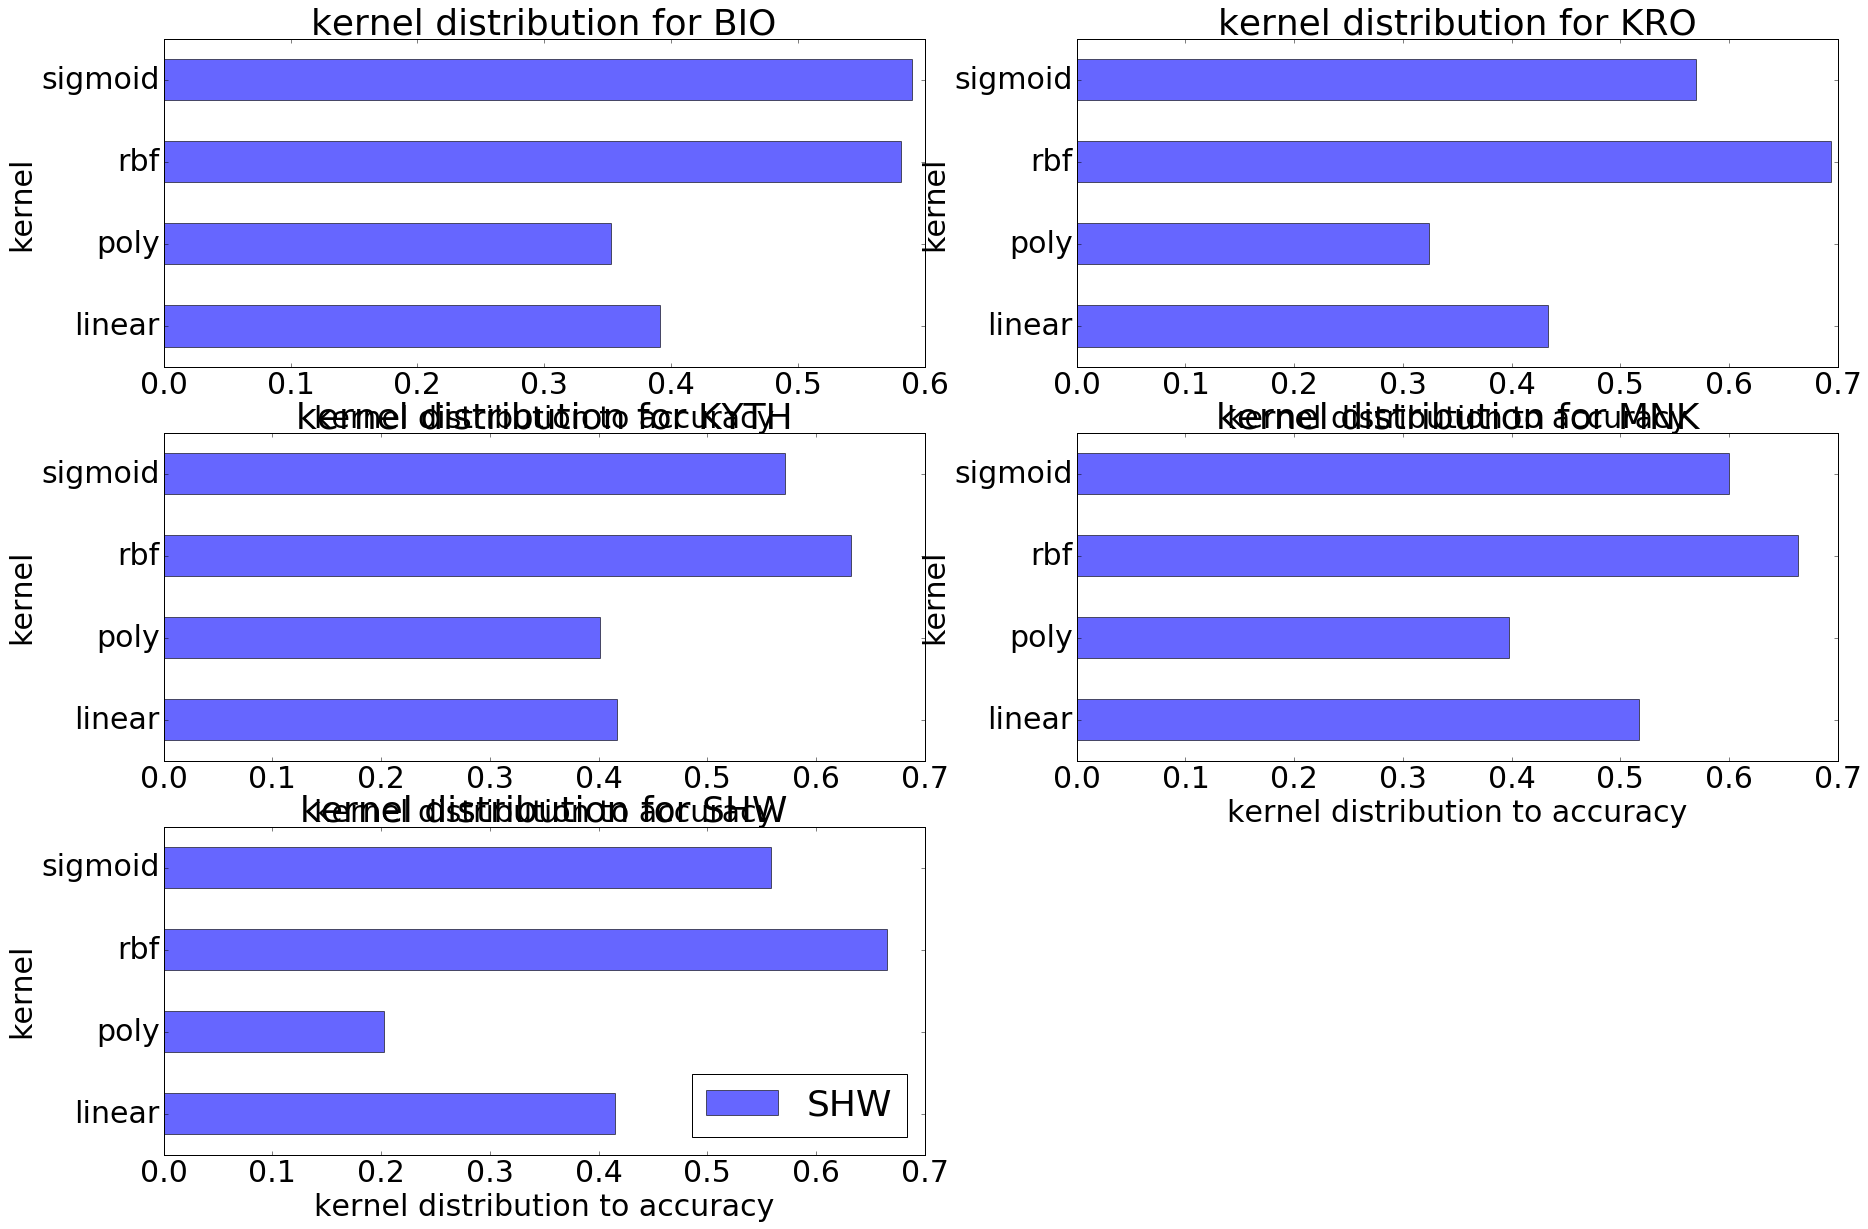

In [9]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(sresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('kernel').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('kernel distribution to accuracy')
    ax1.set_title("kernel distribution for {}".format(name))
plt.legend(loc='best')


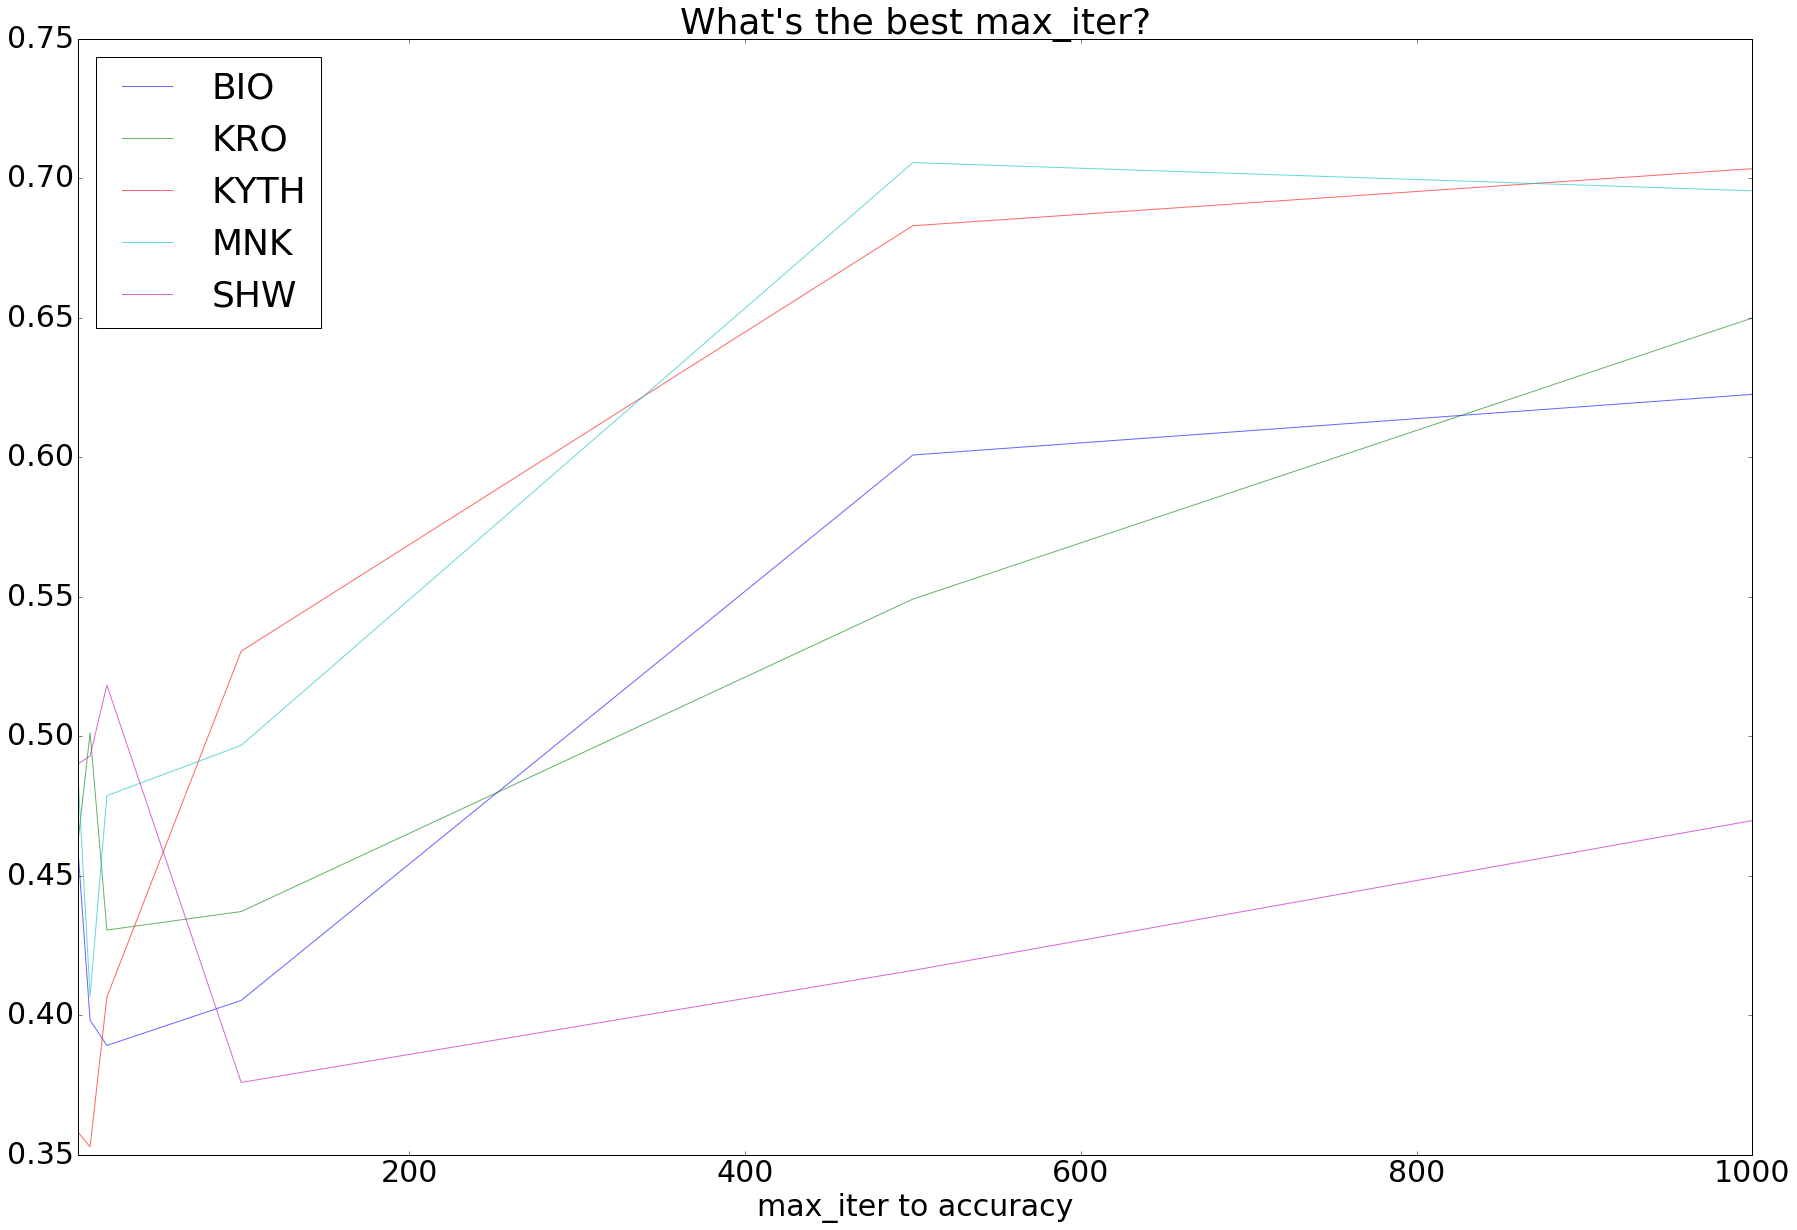

In [10]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max_iter to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_iter?" )

The best average accuracy model is:

In [11]:
print(get_best_model(svm_models, saccuracies))
print(get_best_median_model(svm_models, saccuracies))

(3.889740682769022, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=3, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
(0.79805323105532311, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='sigmoid',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


Which is mostly expected.
Also seems to be the best C value is not hit yet. The problem is that low C ignores mistakes. so we will check if we can have good classification with higher C and more iterations. We will try again with less parameters, medium C values and more iterations.
Let us check:

In [12]:
# create iterables for all options and use itertools product
C=[0.8, 1.0 ,1.5]
max_iter=[1000, 1200, 1500, 2000]

s2models = [SVC(C=c, max_iter=mi) 
          for c, mi in product(C, max_iter)]

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s2accuracies = list(map(run_model, s2models))

In [14]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(s2models, s2accuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.max_iter, sn, acc))

s2results = DataFrame(data, columns=('C', 'max_iter', 'stock', 'accuracy'))

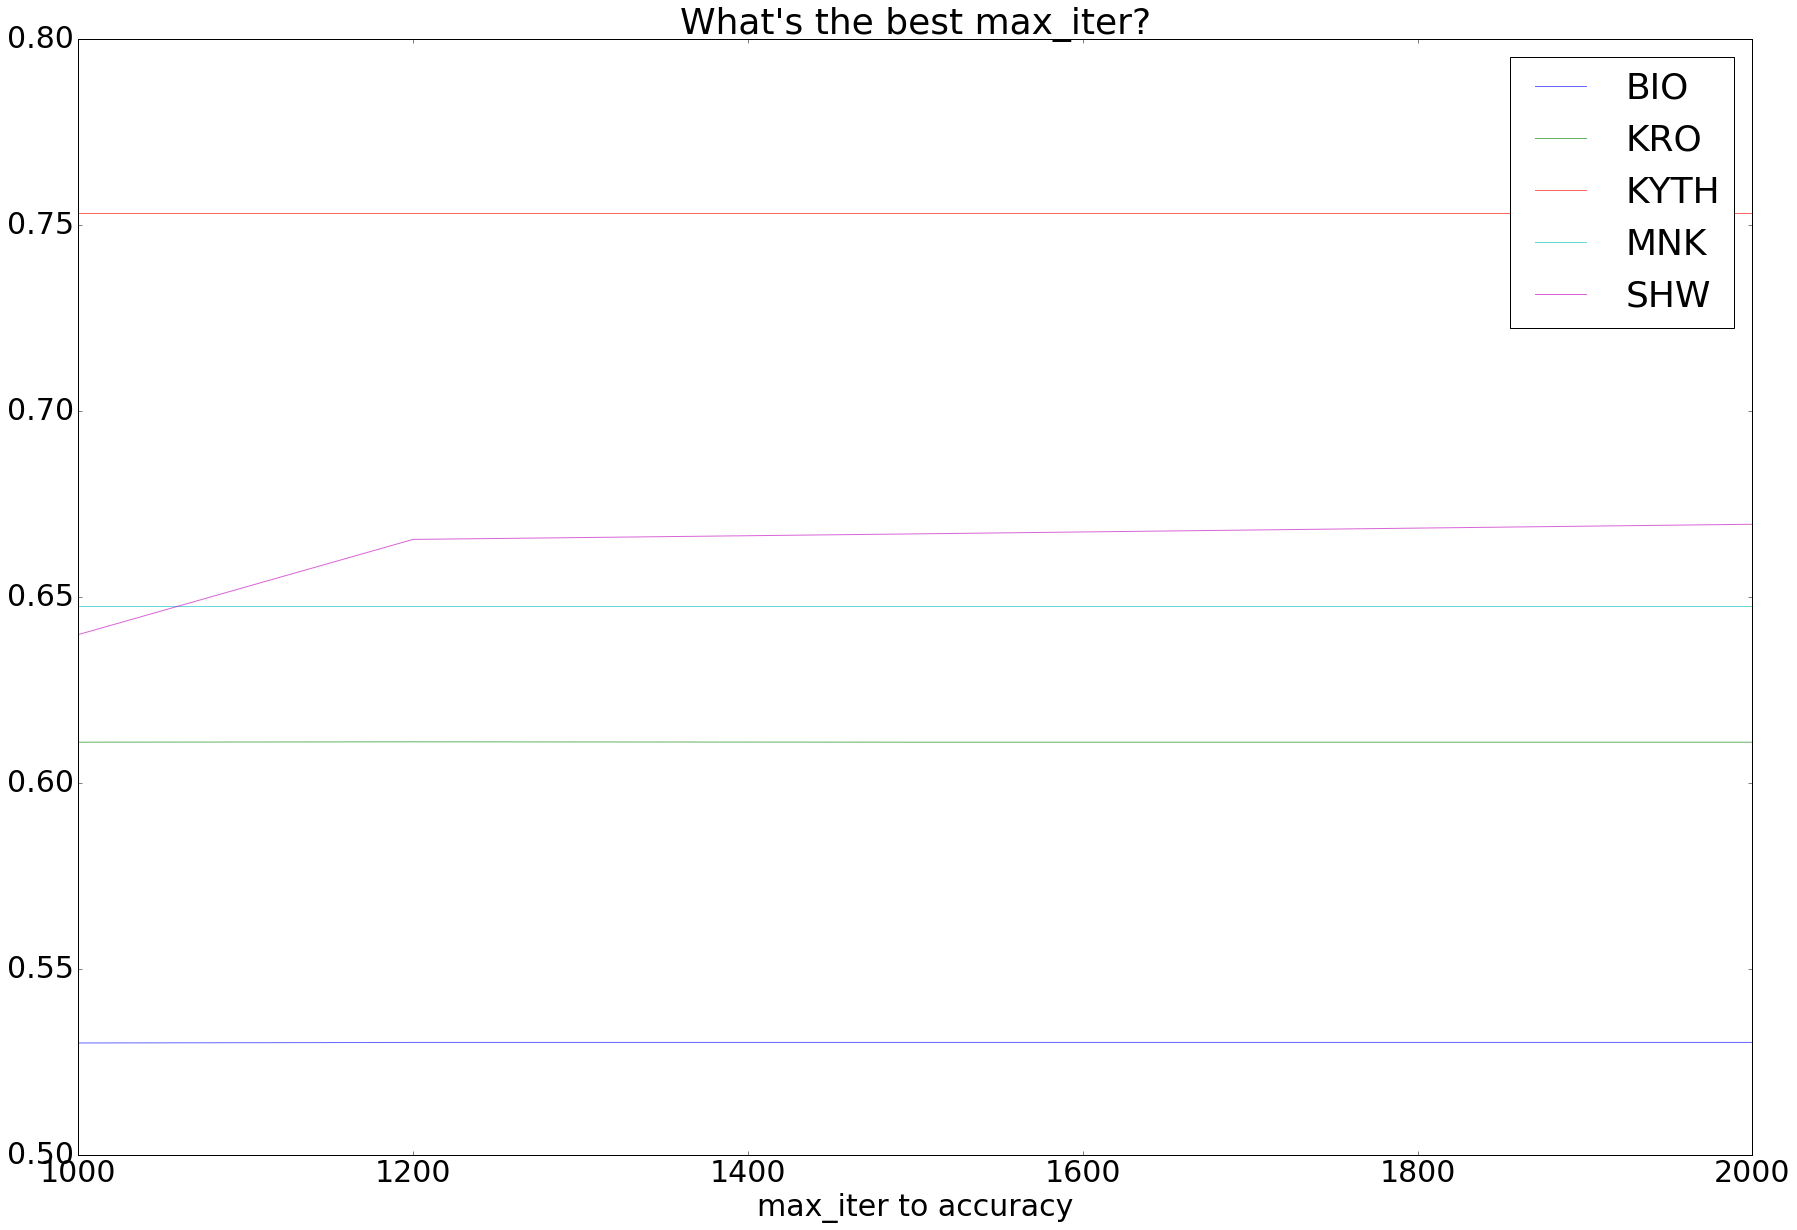

In [15]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in s2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max_iter to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_iter?" )

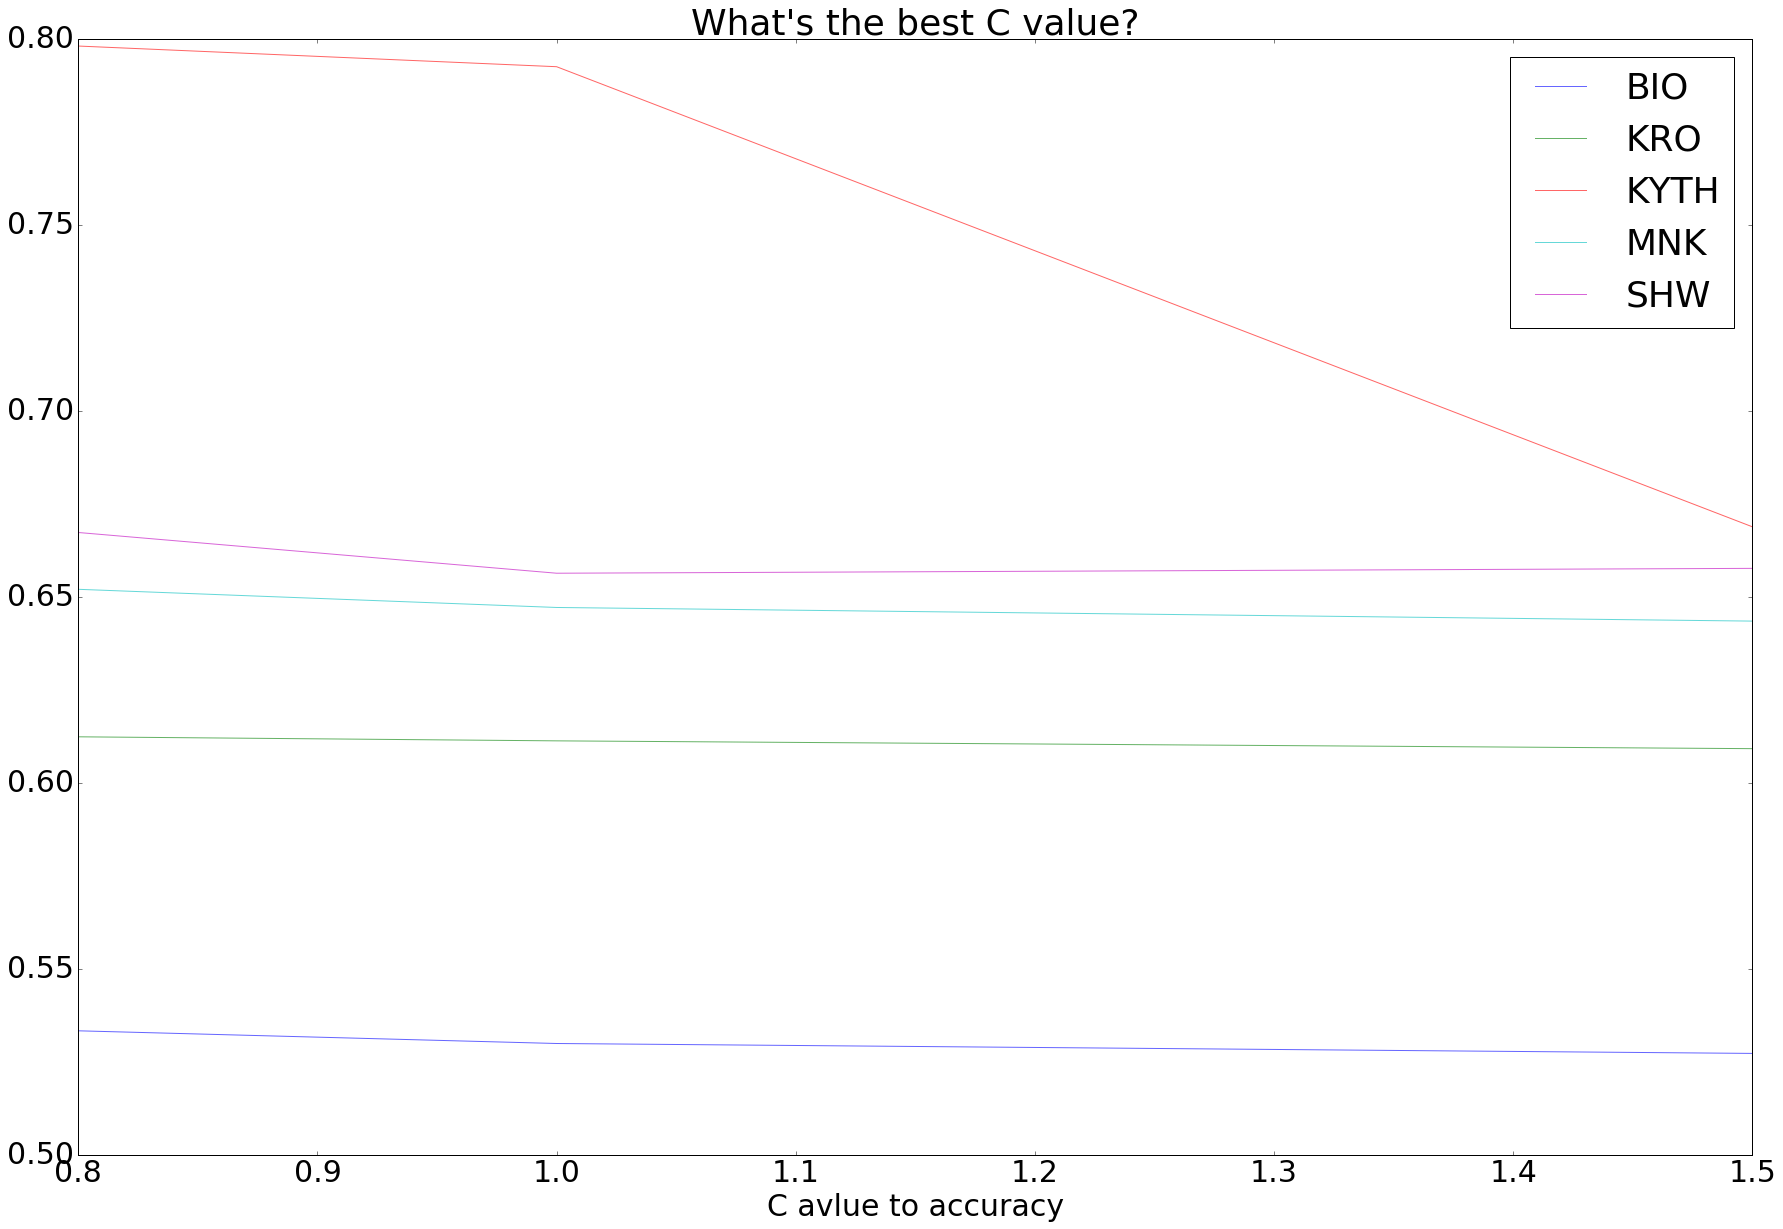

In [16]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in s2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

From checking it seems truly a lower C value should be chosen from what we decide to limit by.
We will need to choose for a C value and kernel=rbf and max_iter>=1200. This gives much better results then trees and we don't need to coerce our data to catagories. And it seems it really influences as the accuracy of BIO dropped really hard because we dont allow svm to be the default classifier


In [17]:
print(get_best_model(s2models, s2accuracies))
print(get_best_median_model(s2models, s2accuracies))

(3.2686156261517438, SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=1500, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
(0.65201465201465203, SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


# Using the Quarter Classifier

In [19]:
import Classifiers
from Classifiers.classifiers import Quarter

q_clusterer = Classifiers.create_quarter_clusterer(ld)

In [20]:
def arrange_data_frame(data: pandas.DataFrame, length: int):
    res = None
    data = data.iloc[0:length]

    for i, c in enumerate(data.columns):
        cur = data[c]
        cur.index = list(range(i*length, (i+1)*length))
        if res is None:
            res = cur
            continue
        res = res.append(cur)
    return res

In [21]:
import functools

quarters = [list(map(lambda q: q.ready_quarter_data(360), Quarter.split_by_quarters(sn, data))) for sn, (data, classes) in zip(stock_names, stocks)]
drop_cols = list(ld.get_stock_data(stock_names[0]).columns)
drop_cols.remove('open')
drop_cols.remove('volume')
quarters = list(functools.reduce(lambda x, y: x+y, quarters))

In [23]:
import collections

c_to_qs = collections.defaultdict(lambda: [])
for q, c in zip(quarters, q_clusterer.predict(list(map(lambda q: arrange_data_frame(q.data, 353), quarters)))):
    c_to_qs[c].append(q)

for c, qs in c_to_qs.items():
    all_dc = [TrainingData(q.name.split('-')[0], startdate=q.start, enddate=q.end, threshold=0.8).add_history(10) for q in qs]
    data = []
    classes = []
    for sn in stock_names:
        temp_d = []
        temp_c = []
        for td in filter(lambda td: td.name == sn, all_dc):
            d, c = td.get()
            temp_d.append(d)
            temp_c.append(c)
        try:
            data.append(functools.reduce(lambda a, b: pandas.concat([a, b]), temp_d))
            classes.append(functools.reduce(lambda a, b: pandas.concat([a, b]), temp_c))
        except:
            continue
    data = [TrainingData.cleanup_data(d) for d in data]

    model1 = get_best_model(s2models, s2accuracies)[1]
    accs = run_model(model1, list(zip(data, classes)))
    print("{}: {}".format(c, accs))



INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015384615384615385
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02437490412639967
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02762554169153026
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.022336245407822683
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.028253915299786922
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.031444170485059146
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024393431464306954
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.030122462125787196
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.017039430449069068
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.011381314755117547
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.012296299918101841
INFO:root:Tr

date
2016-04-01     True
2016-04-04    False
2016-04-05    False
2016-04-06    False
2016-04-07     True
2016-04-08    False
2016-04-11     True
2016-04-12    False
2016-04-13    False
2016-04-14    False
2016-04-15     True
2016-04-18    False
2016-04-19     True
2016-04-20    False
2016-04-21    False
2016-04-22    False
2016-04-25    False
2016-04-26    False
2016-04-27    False
2016-04-28    False
2016-04-29    False
2016-05-02    False
2016-05-03     True
2016-05-04    False
2016-05-05     True
2016-05-06     True
2016-05-09     True
2016-05-10    False
2016-05-11    False
2016-05-12     True
2016-05-13    False
2016-05-16    False
2016-05-17    False
2016-05-18    False
2016-05-19    False
2016-05-20    False
2016-05-23    False
2016-05-24    False
2016-05-25    False
2016-05-26    False
2016-05-27    False
2016-05-31    False
2016-06-01    False
2016-06-02    False
2016-06-03    False
2016-06-06    False
2016-06-07    False
2016-06-08    False
2016-06-09     True
2016-06-10    F

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014561780175750775
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.010470521895491898
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.021123329480709264
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.019318005366236752
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.012185466879709703
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.009341612687796479
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.03136893998147969



date
2011-04-01    False
2011-04-04    False
2011-04-05    False
2011-04-06    False
2011-04-07    False
2011-04-08    False
2011-04-11    False
2011-04-12    False
2011-04-13    False
2011-04-14    False
2011-04-15    False
2011-04-18    False
2011-04-19    False
2011-04-20    False
2011-04-21    False
2011-04-25    False
2011-04-26    False
2011-04-27    False
2011-04-28    False
2011-04-29    False
2011-05-02    False
2011-05-03    False
2011-05-04     True
2011-05-05     True
2011-05-06    False
2011-05-09    False
2011-05-10    False
2011-05-11    False
2011-05-12     True
2011-05-13    False
2011-05-16    False
2011-05-17    False
2011-05-18     True
2011-05-19    False
2011-05-20    False
2011-05-23    False
2011-05-24    False
2011-05-25    False
2011-05-26    False
2011-05-27     True
2011-05-31     True
2011-06-01    False
2011-06-02    False
2011-06-03    False
2011-06-06    False
2011-06-07    False
2011-06-08    False
2011-06-09    False
2011-06-10    False
2011-06-13    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0238815467021425
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.010627930741388071
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013781512605042005
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.011651678914481971
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01511784175165661
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013291602851652297
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014380000186028159
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.012995382801272702
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.008780129278374625



date
2016-07-01    False
2016-07-05     True
2016-07-06     True
2016-07-07    False
2016-07-08    False
2016-07-11    False
2016-07-12    False
2016-07-13    False
2016-07-14    False
2016-07-15    False
2016-07-18    False
2016-07-19    False
2016-07-20    False
2016-07-21    False
2016-07-22    False
2016-07-25    False
2016-07-26     True
2016-07-27    False
2016-07-28    False
2016-07-29    False
2016-08-01     True
2016-08-02     True
2016-08-03    False
2016-08-04     True
2016-08-05    False
2016-08-08     True
2016-08-09    False
2016-08-10    False
2016-08-11    False
2016-08-12    False
2016-08-15    False
2016-08-16    False
2016-08-17    False
2016-08-18    False
2016-08-19    False
2016-08-22    False
2016-08-23    False
2016-08-24     True
2016-08-25    False
2016-08-26    False
2016-08-29    False
2016-08-30    False
2016-08-31     True
2016-09-01    False
2016-09-02    False
2016-09-06    False
2016-09-07     True
2016-09-08    False
2016-09-09    False
2016-09-12    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015064332879268016
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014738988535103095
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01983459347746907
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.019141486357994775
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015748297045368686
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01974073262011865
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.02292420223217502
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.047043384286527545
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.029637052310462292
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.01871313399985338
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.026092313422972642
INFO:root:Trai

AutoReconnect: connection closed